In [1]:
# Step 1: Load necessary libraries
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Step 2: Load the preprocessed dataset from Week 1
df = pd.read_csv("processed_data.csv")

In [3]:
# Split data into features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

In [10]:
## Step 4: Fraud Transactions Per Hour (Bar Chart)
# Filter fraud transactions only
fraud = df[df['Class'] == 1].copy()

In [5]:
# Extract hour from 'Time' column
fraud['Hour'] = fraud['Time'].apply(lambda x: int(x // 3600) % 24)

In [6]:
# Count number of frauds per hour
fraud_hour_counts = fraud['Hour'].value_counts().sort_index()
fraud_hour_df = fraud_hour_counts.reset_index()
fraud_hour_df.columns = ['Hour', 'Count']

In [8]:
# Create bar chart to show fraud distribution by hour
fig = px.bar(
    fraud_hour_df,
    x='Hour',
    y='Count',
    title='Fraud Transactions per Hour',
    labels={'Hour': 'Hour of Day', 'Count': 'Fraud Transactions'},
    color='Count',
    color_continuous_scale='Reds'
)
fig.update_layout(bargap=0.2)
fig.show()

In [11]:
##  Step 5: Save X and y for Modeling
# Save features and labels for use in Week 3
X.to_csv("X_features.csv", index=False)
y.to_csv("y_labels.csv", index=False)

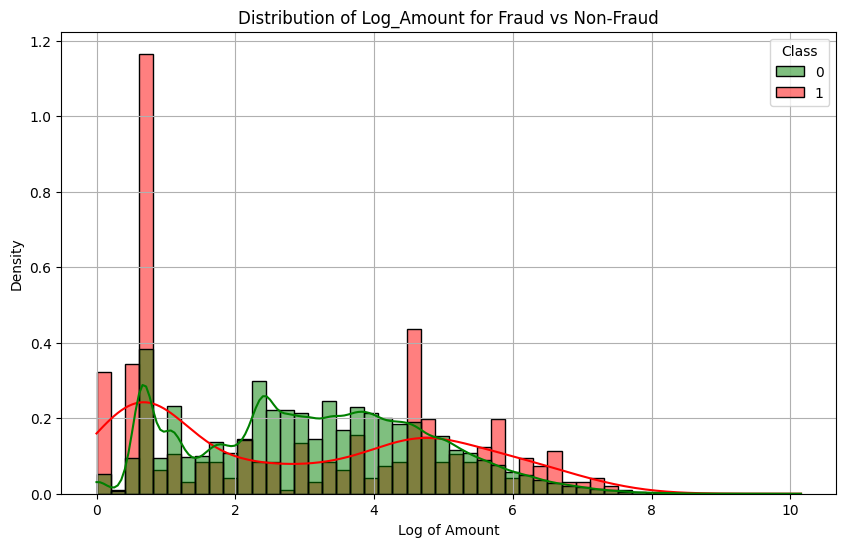

In [12]:
## Step6: Log_Amount Distribution for Fraud vs Non-Fraud Transactions
# Visualize distribution of transaction amount (log scale) for fraud vs non-fraud
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df,
    x='Log_Amount',
    hue='Class',
    bins=50,
    palette={0: 'green', 1: 'red'},
    kde=True,
    stat='density',
    common_norm=False
)
plt.title('Distribution of Log_Amount for Fraud vs Non-Fraud')
plt.xlabel('Log of Amount')
plt.ylabel('Density')
plt.grid(True)
plt.show()


Green bars = Normal transactions

Red bars = Fraudulent transactions

This will help us visualize whether fraud transactions occur more frequently at lower amounts or higher amounts.

In [13]:
## Step 7: Hour vs Amount (Scatter Plot for Fraud)

# Create scatter plot: Hour vs Log_Amount for fraud transactions
fraud = df[df['Class'] == 1].copy()
fraud['Hour'] = fraud['Time'].apply(lambda x: int(x // 3600) % 24)

fig = px.scatter(
    fraud,
    x='Hour',
    y='Log_Amount',
    title='Fraud Transactions: Hour vs Log Amount',
    labels={'Hour': 'Hour of Transaction', 'Log_Amount': 'Log of Amount'},
    color_discrete_sequence=['red']
)
fig.update_traces(marker=dict(size=5))
fig.show()

If most points are clustered around a specific hour → that time period is considered high risk.

If points with low or high amounts are repeating → that amount range is considered suspicious.

We visualized fraud and non-fraud transaction patterns using Log_Amount and Hour. 

Histograms and scatter plots revealed behavioral differences across time and amount,
 helping us identify fraud-prone hours and transaction ranges.

In [10]:
#Day 3: Correlation Analysis with Class

In [14]:
## Step 8: Correlation with Target Class

# Compute correlation matrix
corr_matrix = df.corr()

# Get top 10 most correlated features with target (Class)
top_corr = corr_matrix['Class'].abs().sort_values(ascending=False).head(11)


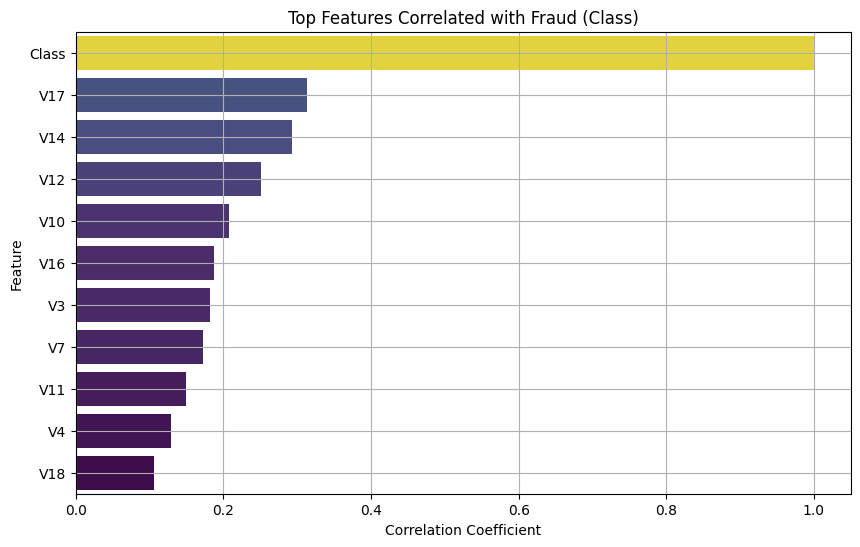

In [15]:
# Plot correlation as a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis', hue=top_corr, legend=False)
plt.title("Top Features Correlated with Fraud (Class)")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

In [16]:
## Step 9: Select Top Correlated Features

# Get top 10 feature names (excluding target 'Class')
top_features = corr_matrix['Class'].abs().sort_values(ascending=False).drop('Class').head(10).index.tolist()

In [17]:
# Print selected feature names
print("Top Correlated Features with Class (Fraud):")
print(top_features)

Top Correlated Features with Class (Fraud):
['V17', 'V14', 'V12', 'V10', 'V16', 'V3', 'V7', 'V11', 'V4', 'V18']


In [18]:
# Create new DataFrame with only top features + Class column
df_top = df[top_features + ['Class']]

Visualize Distribution of Top Correlated Features

In [19]:
### Step 10: KDE Plot of Top Features

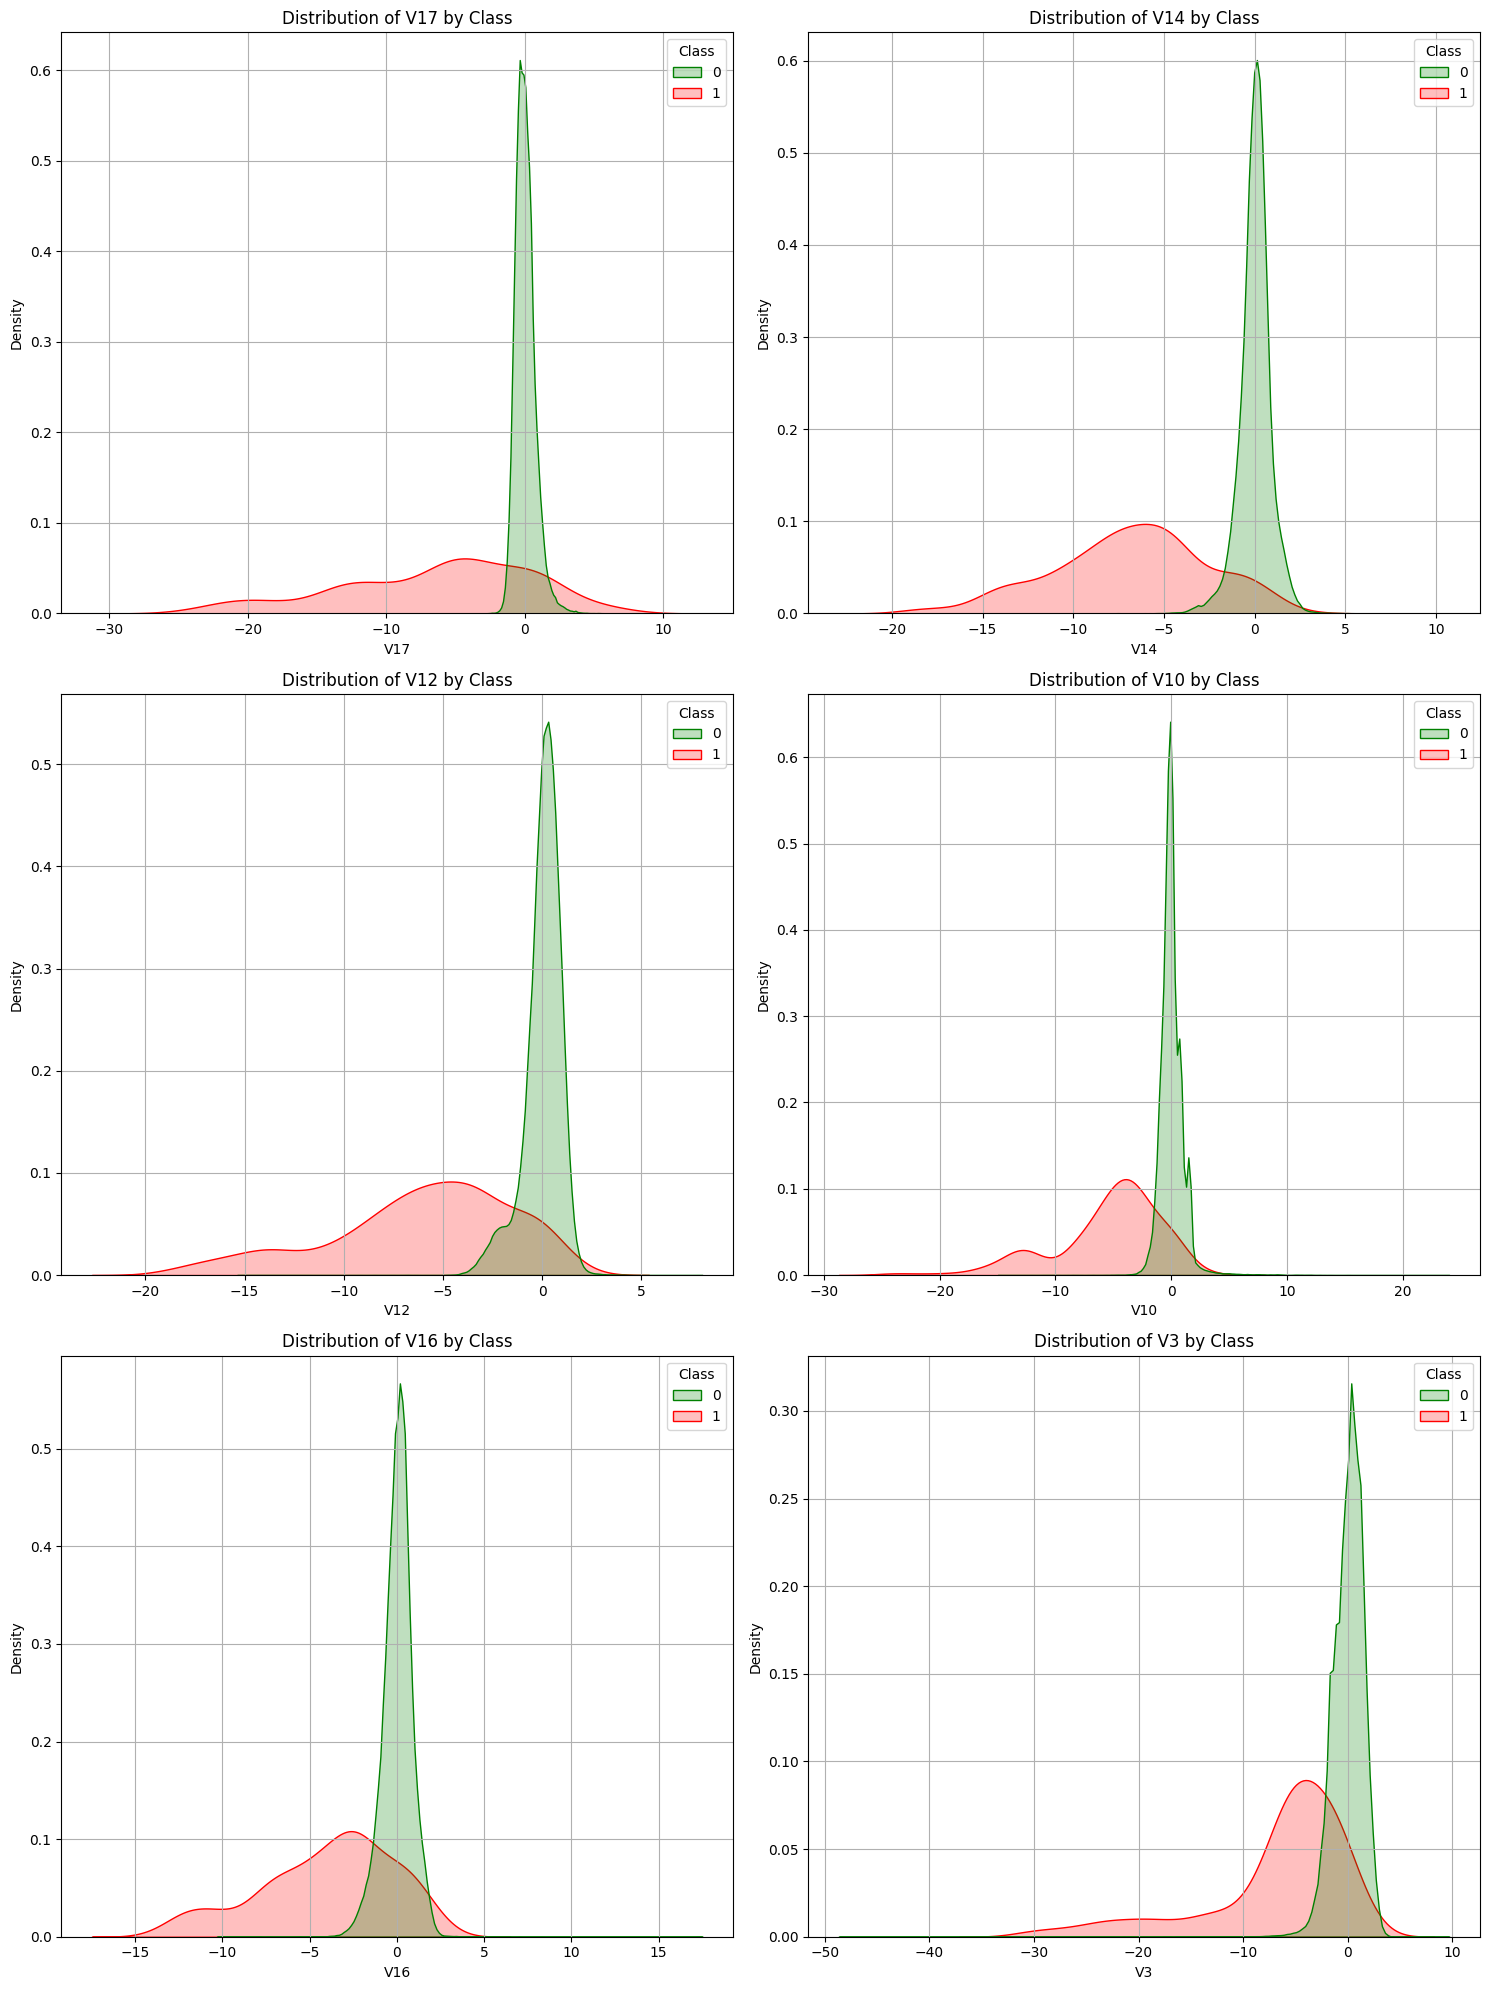

In [20]:
# KDE plot for each top feature split by Class
plt.figure(figsize=(15, 20))

for i, feature in enumerate(top_features[:6], 1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=df, x=feature, hue='Class', fill=True, common_norm=False, palette={0:'green', 1:'red'})
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid(True)

plt.tight_layout()
plt.show()

If the fraud (red) curve is different from the normal (green) curve → the feature is helpful.

If both curves overlap on the same pattern → the feature is less useful.

We identified top 6 features most correlated with fraud and visualized their distribution. These features showed clear separation between fraud and non-fraud transactions, making them valuable for the modeling phase.

-----------------------------------------------------------------------------------------------------------------------------------------------------

### Day 4: Dimensionality Reduction or Top Feature Selection karenge

In [21]:
## Step 11: Feature Selection using SelectKBest


In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

In [24]:
# Apply SelectKBest to get best features
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)

In [25]:
# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Top 10 selected features:")
print(selected_features)

Top 10 selected features:
Index(['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'], dtype='object')


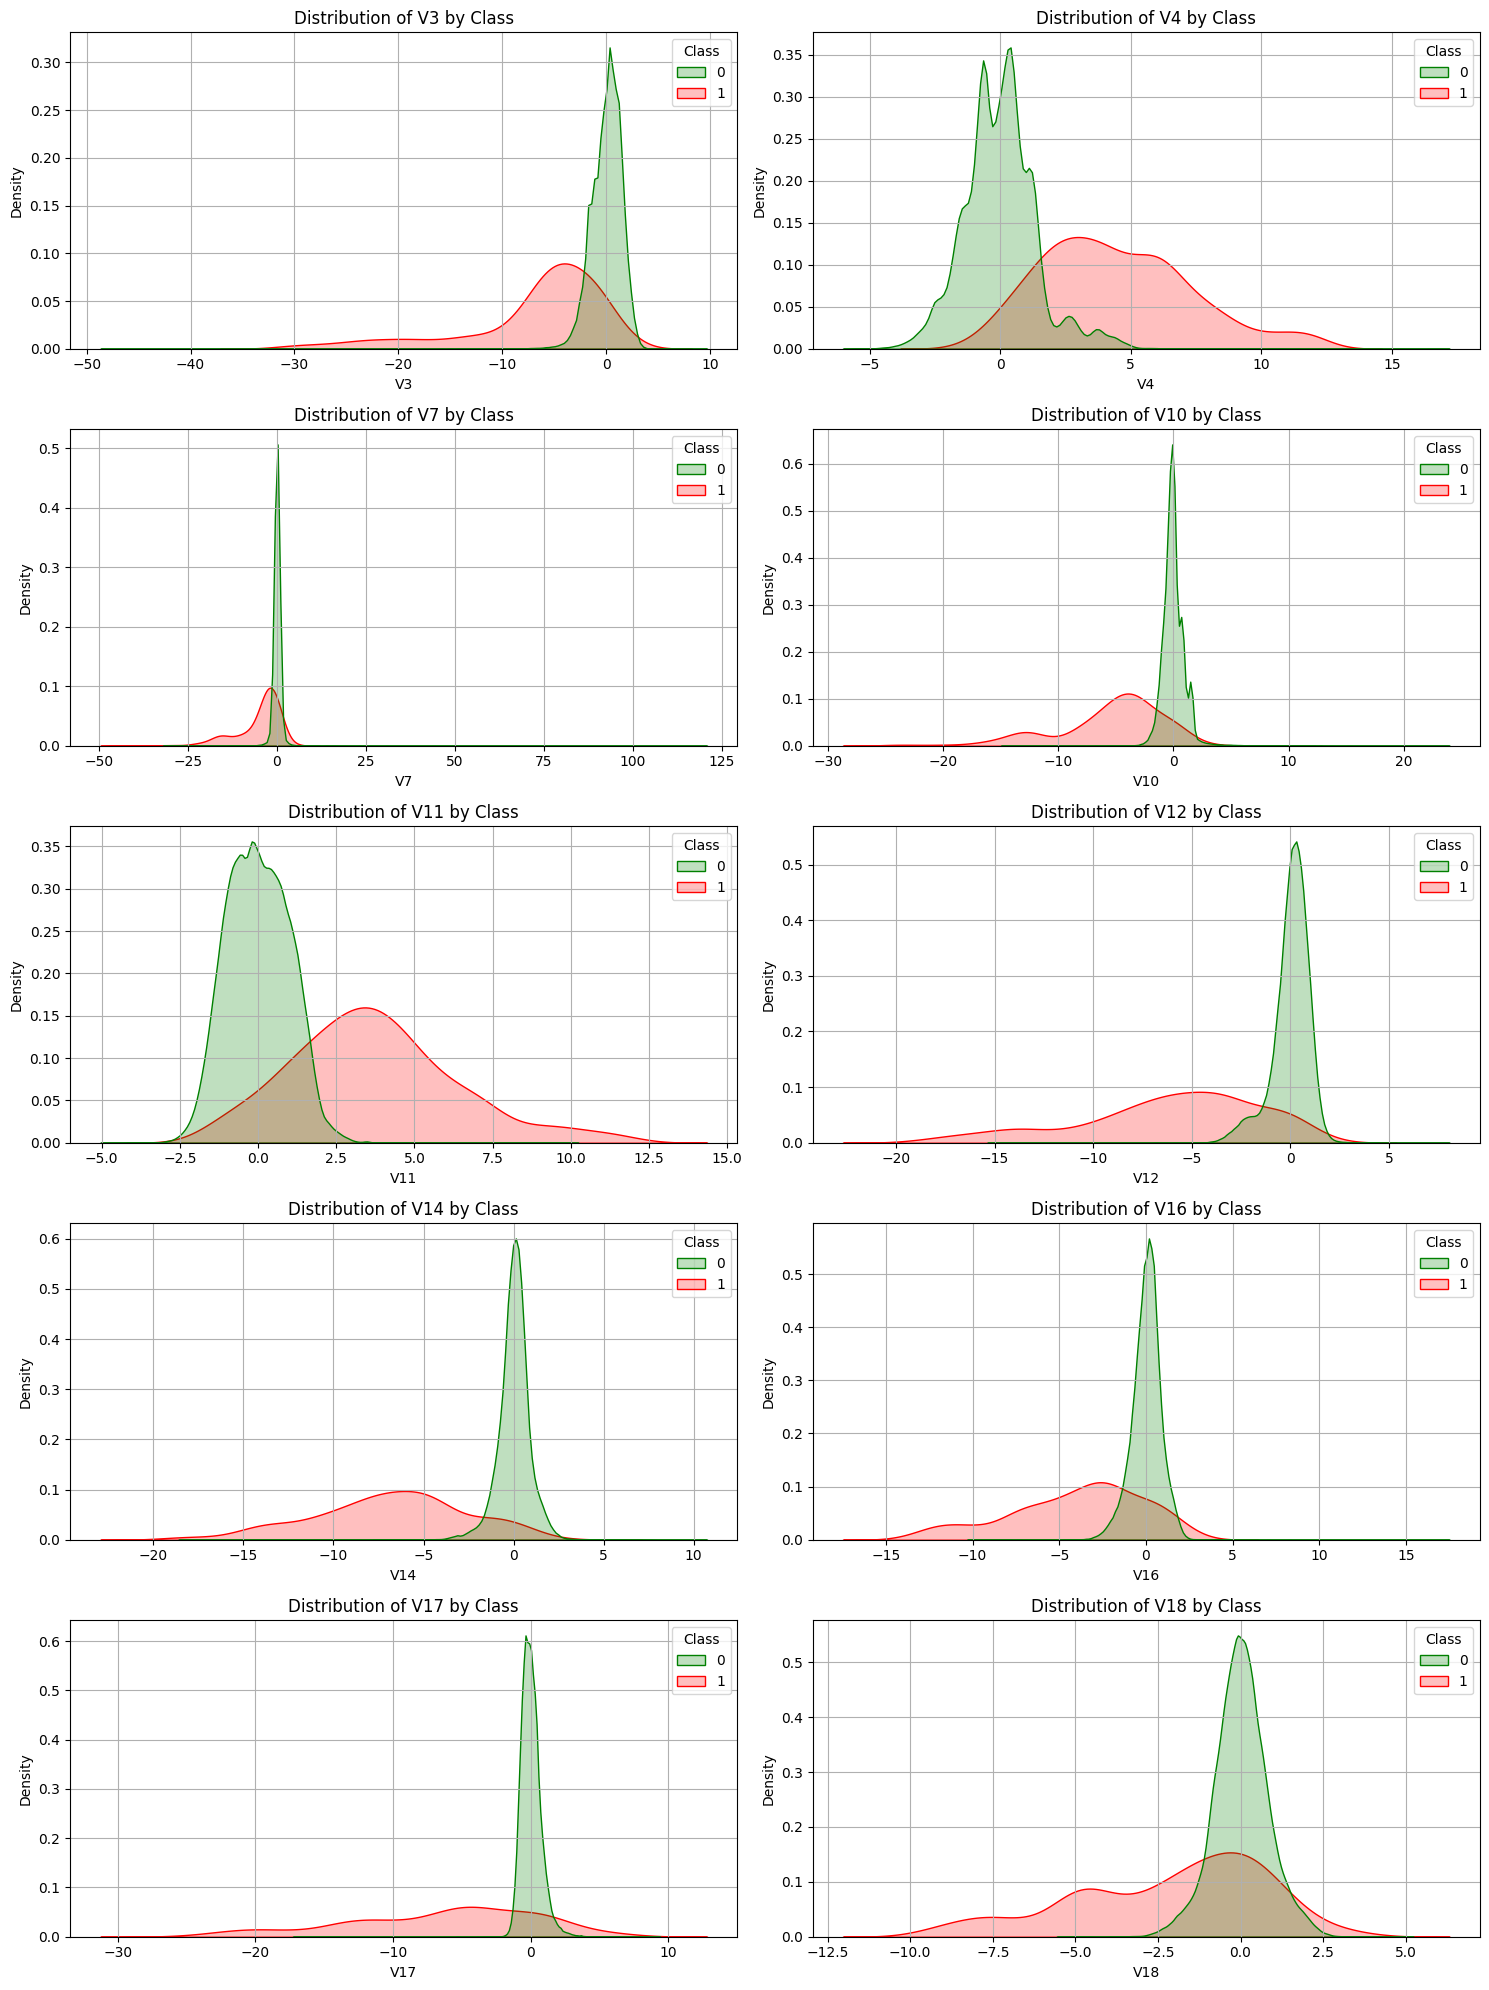

In [26]:
# KDE plot for selected features
plt.figure(figsize=(15, 20))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(5, 2, i)
    sns.kdeplot(data=df, x=feature, hue='Class', fill=True, common_norm=False, palette={0:'green', 1:'red'})
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid(True)

plt.tight_layout()
plt.show()


We selected top 10 features using SelectKBest with f_classif, and visualized their class-wise distributions. These plots confirmed the usefulness of selected features for distinguishing between fraud and non-fraud transactions.

-----------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
##  Step 13: Final Dataset Creation

In [28]:
# Create final dataset with selected features + target
final_df = df[selected_features.tolist() + ['Class']]

In [29]:
# Check shape
print("Final dataset shape:", final_df.shape)

Final dataset shape: (283726, 11)


In [30]:
# Preview first few rows
final_df.head()

,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18,Class
0,2.536347,1.378155,0.239599,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0
1,0.166480,0.448154,-0.078803,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,0
2,1.773209,0.379780,0.791461,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,0
3,1.792993,-0.863291,0.237609,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,0
4,1.548718,0.403034,0.592941,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0


In [32]:
### Step 14: Split into Train and Test

In [33]:
#Split Final Data into Train & Test

from sklearn.model_selection import train_test_split


In [34]:
# Train-test split (80-20)
X = final_df.drop('Class', axis=1)
y = final_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Show dimensions
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (226980, 10)
Test shape: (56746, 10)


In [36]:
# Combine X and y for export
final_data = pd.concat([X, y], axis=1)


In [37]:
# Save cleaned dataset
final_data.to_csv("cleaned_selected_features_dataset.csv", index=False)
print("Final dataset saved successfully!")

Final dataset saved successfully!


In Week 2, we performed exploratory data analysis (EDA) to better understand fraud patterns in the dataset. We visualized fraud transactions by hour and studied how transaction amounts differ between fraud and non-fraud cases using histograms and scatter plots. Next, we calculated correlation scores to identify features most linked to fraudulent behavior. We used both correlation and SelectKBest methods to select the top 10 important features. Finally, we split the data into training and testing sets (80/20 split) and saved the cleaned dataset (cleaned_selected_features_dataset.csv) for modeling in Week 3.